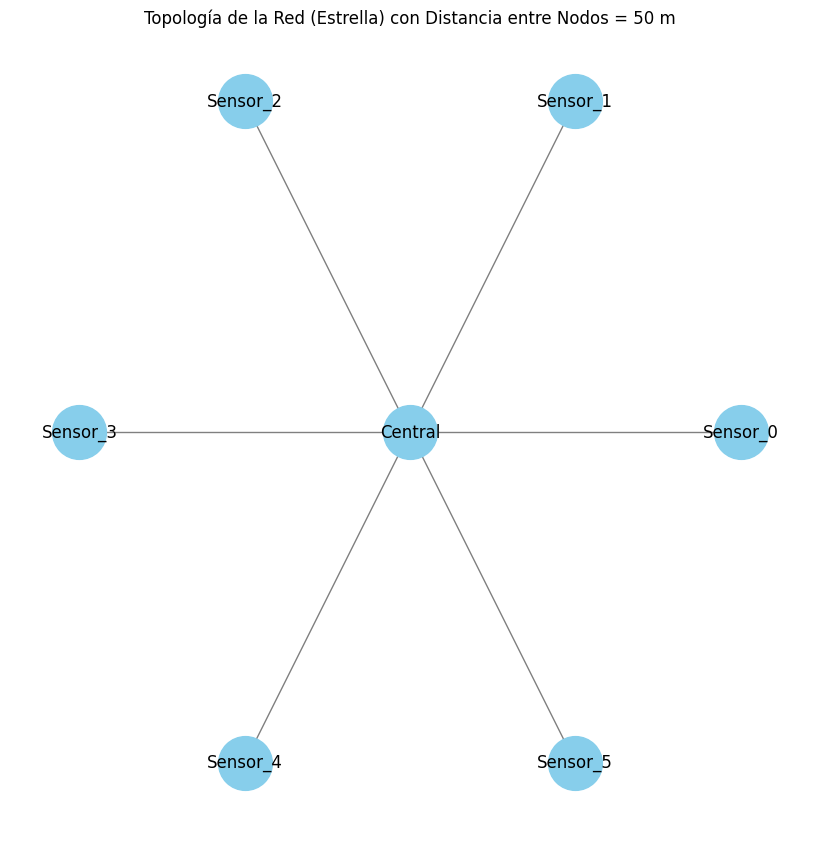

KeyError: None

In [14]:
# Importar librerías necesarias
import simpy
import random
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Parámetros generales
TIEMPO_SIMULACION = 100    # Tiempo total de simulación en segundos

# Tipos de datos y sus tamaños (en KB)
TIPOS_DATOS = {
    'temperatura': 1,
    'voltaje': 1,
    'corriente': 1,
    'potencia': 1,
    'foto': 500   # Las fotos son más grandes
}

# Tecnologías de comunicación
TECNOLOGIAS = {
    'WiFi': {
        'velocidad': 1000,    # KB/s
        'alcance': 100,       # metros
        'tasa_perdida': 0.05  # Probabilidad de pérdida de paquetes
    },
    'LoRa': {
        'velocidad': 10,      # KB/s
        'alcance': 5000,      # metros
        'tasa_perdida': 0.1   # Probabilidad de pérdida de paquetes
    }
}

# Parámetros de la red
NUM_NODOS = 6
TOPOLOGIA = 'estrella'      # Puede ser 'estrella' o 'mesh'
DISTANCIA_NODOS = 50        # Distancia promedio entre nodos en metros
TECNOLOGIA = 'WiFi'         # Tecnología de comunicación a utilizar

# Crear el entorno de SimPy
env = simpy.Environment()

# Crear la red utilizando NetworkX
G = nx.Graph()
nodo_central = 'Central'
nodos_sensores = [f'Sensor_{i}' for i in range(NUM_NODOS)]

# Añadir nodos al grafo
G.add_node(nodo_central, pos=(0, 0))  # Nodo central en el origen

# Posicionar los nodos sensores alrededor del nodo central
for i, sensor in enumerate(nodos_sensores):
    angle = i * (360 / NUM_NODOS)
    x = DISTANCIA_NODOS * np.cos(np.deg2rad(angle))
    y = DISTANCIA_NODOS * np.sin(np.deg2rad(angle))
    G.add_node(sensor, pos=(x, y))

    if TOPOLOGIA == 'estrella':
        G.add_edge(nodo_central, sensor)
    elif TOPOLOGIA == 'mesh':
        # Conectar cada nodo con todos los demás
        for other_sensor in nodos_sensores:
            if sensor != other_sensor:
                G.add_edge(sensor, other_sensor)

# Dibujar la red
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(8, 8))
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1500, edge_color='gray')
plt.title(f'Topología de la Red ({TOPOLOGIA.capitalize()}) con Distancia entre Nodos = {DISTANCIA_NODOS} m')
plt.show()

# Definir la clase NodoSensor
class NodoSensor:
    def __init__(self, env, id_nodo, tecnologia, tipos_datos, nodo_central=None):
        self.env = env
        self.id_nodo = id_nodo
        self.tecnologia = tecnologia
        self.tipos_datos = tipos_datos
        # Asegurarse de que nodo_central no sea None
        self.nodo_central = nodo_central if nodo_central is not None else 'Central'
        self.env.process(self.enviar_datos())
        self.datos_enviados = []
        self.packets_sent = 0
        self.packets_lost = 0
        self.datos_recibidos = []
        self.packets_received = 0
    
    def distancia_a(self, otro_nodo):
        pos1 = G.nodes[self.id_nodo]['pos']
        pos2 = G.nodes[otro_nodo]['pos']
        distancia = np.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)
        return distancia
    
    def generar_datos_sensor(self):
        datos_sensor = {}
        for dato in self.tipos_datos:
            if dato == 'temperatura':
                valor = random.uniform(20.0, 30.0)
            elif dato == 'voltaje':
                valor = random.uniform(18.0, 22.0)
            elif dato == 'corriente':
                valor = random.uniform(5.0, 10.0)
            elif dato == 'potencia':
                valor = random.uniform(100.0, 220.0)
            elif dato == 'foto':
                valor = f"foto_{self.env.now}_{self.id_nodo}.jpg"
            datos_sensor[dato] = valor
        return datos_sensor
    
    def enviar_datos(self):
        while True:
            # Generar datos del sensor
            datos_sensor = self.generar_datos_sensor()
            tamano_paquete = sum([TIPOS_DATOS[dato] for dato in self.tipos_datos])
            datos = {
                'nodo': self.id_nodo,
                'tiempo_envio': self.env.now,
                'datos_sensor': datos_sensor,
                'tamano': tamano_paquete  # Tamaño del paquete en KB
            }
            self.datos_enviados.append(datos)
            self.packets_sent += 1

            # Obtener vecinos a los que enviar datos
            if TOPOLOGIA == 'estrella':
                destinos = [self.nodo_central]
            else:
                destinos = list(G.neighbors(self.id_nodo))

            for destino in destinos:
                distancia = self.distancia_a(destino)
                alcance = TECNOLOGIAS[self.tecnologia]['alcance']
                if distancia <= alcance:
                    # Simular la posible pérdida de paquetes
                    if random.random() > TECNOLOGIAS[self.tecnologia]['tasa_perdida']:
                        # Calcular tiempo de transmisión
                        velocidad = TECNOLOGIAS[self.tecnologia]['velocidad']
                        tiempo_transmision = datos['tamano'] / velocidad
                        yield self.env.timeout(tiempo_transmision)
                        # Enviar datos al destino
                        env.process(nodos[destino].recibir_datos(datos, self))
                    else:
                        # El paquete se pierde
                        self.packets_lost += 1
                        print(f"Tiempo {self.env.now:.2f}s: Nodo {self.id_nodo} perdió un paquete al enviar a {destino}")
                else:
                    # El destino está fuera de alcance
                    self.packets_lost += 1
                    print(f"Tiempo {self.env.now:.2f}s: Nodo {self.id_nodo} no puede alcanzar a {destino} (Distancia: {distancia:.2f} m)")
            
            # Esperar hasta el próximo envío
            yield self.env.timeout(INTERVALO_ENVIO)
    
    def recibir_datos(self, datos, nodo_emisor):
        # Simular retraso en la recepción
        velocidad = TECNOLOGIAS[self.tecnologia]['velocidad']
        tiempo_procesamiento = datos['tamano'] / (velocidad * 2)
        yield self.env.timeout(tiempo_procesamiento)
        datos['tiempo_recepcion'] = self.env.now
        self.datos_recibidos.append(datos)
        self.packets_received += 1
        # Calcular latencia
        latencia = datos['tiempo_recepcion'] - datos['tiempo_envio']
        print(f"Tiempo {self.env.now:.2f}s: {self.id_nodo} recibió datos de {datos['nodo']} (Latencia: {latencia:.2f}s)")

# Definir la clase NodoCentral
class NodoCentral(NodoSensor):
    def __init__(self, env, id_nodo, tecnologia, tipos_datos):
        super().__init__(env, id_nodo, tecnologia, tipos_datos)

# Definir los tipos de datos a enviar
tipos_datos_a_enviar = ['temperatura', 'voltaje', 'corriente', 'foto']

# Definir el intervalo de envío de datos
INTERVALO_ENVIO = 10  # segundos

# Crear diccionario de nodos
nodos = {}

# Crear el nodo central
nodo_central_obj = NodoCentral(env, nodo_central, TECNOLOGIA, tipos_datos_a_enviar)
nodos[nodo_central_obj.id_nodo] = nodo_central_obj

# Crear los nodos sensores (modificar esta parte)
for sensor_id in nodos_sensores:
    nodo = NodoSensor(env, sensor_id, TECNOLOGIA, tipos_datos_a_enviar, 'Central')  # Usar 'Central' en lugar de nodo_central_obj.id_nodo
    nodos[sensor_id] = nodo

# Ejecutar la simulación
env.run(until=TIEMPO_SIMULACION)

# Análisis del rendimiento de la red
# Recopilar datos enviados y recibidos por cada nodo
datos_enviados = []
datos_recibidos_central = nodo_central_obj.datos_recibidos

for nodo in nodos.values():
    if nodo.id_nodo != nodo_central_obj.id_nodo:
        datos_enviados.extend(nodo.datos_enviados)

df_enviados = pd.DataFrame(datos_enviados)
df_recibidos = pd.DataFrame(datos_recibidos_central)

# Calcular la latencia de cada paquete recibido
if not df_recibidos.empty:
    df_recibidos['latencia'] = df_recibidos['tiempo_recepcion'] - df_recibidos['tiempo_envio']
else:
    df_recibidos['latencia'] = []

# Ancho de banda utilizado (KB/s)
if not df_recibidos.empty:
    df_recibidos['intervalo'] = df_recibidos['tiempo_recepcion'].astype(int)
    ancho_banda = df_recibidos.groupby('intervalo')['tamano'].sum()
else:
    ancho_banda = pd.Series()

# Tasa de pérdida de paquetes por nodo
tasa_perdida_por_nodo = []
for nodo in nodos.values():
    if nodo.id_nodo != nodo_central_obj.id_nodo:
        paquetes_enviados = nodo.packets_sent
        paquetes_perdidos = nodo.packets_lost
        tasa_perdida = (paquetes_perdidos / paquetes_enviados) * 100 if paquetes_enviados > 0 else 0
        tasa_perdida_por_nodo.append({
            'nodo': nodo.id_nodo,
            'paquetes_enviados': paquetes_enviados,
            'paquetes_perdidos': paquetes_perdidos,
            'tasa_perdida': tasa_perdida
        })
df_tasa_perdida = pd.DataFrame(tasa_perdida_por_nodo)

# Gráfico de latencia por nodo
if not df_recibidos.empty:
    plt.figure(figsize=(10,6))
    for nodo_id in df_recibidos['nodo'].unique():
        df_nodo = df_recibidos[df_recibidos['nodo'] == nodo_id]
        plt.plot(df_nodo['tiempo_recepcion'], df_nodo['latencia'], marker='o', label=nodo_id)
    
    plt.xlabel('Tiempo de Recepción (s)')
    plt.ylabel('Latencia (s)')
    plt.title('Latencia de los paquetes recibidos por el Nodo Central')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No hay datos recibidos para calcular la latencia.")

# Gráfico de ancho de banda utilizado
if not ancho_banda.empty:
    plt.figure(figsize=(10,6))
    plt.bar(ancho_banda.index, ancho_banda.values)
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Datos Recibidos (KB)')
    plt.title('Ancho de Banda Utilizado por Segundo')
    plt.grid(True)
    plt.show()
else:
    print("No hay datos recibidos para calcular el ancho de banda.")

# Gráfico de tasa de pérdida de paquetes por nodo
plt.figure(figsize=(10,6))
plt.bar(df_tasa_perdida['nodo'], df_tasa_perdida['tasa_perdida'])
plt.xlabel('Nodo')
plt.ylabel('Tasa de Pérdida (%)')
plt.title('Tasa de Pérdida de Paquetes por Nodo')
plt.grid(True)
plt.show()

# Gráfico de temperatura reportada por los sensores
if not df_enviados.empty:
    plt.figure(figsize=(10,6))
    for nodo_id in df_enviados['nodo'].unique():
        df_nodo = df_enviados[df_enviados['nodo'] == nodo_id]
        temperaturas = [datos['temperatura'] for datos in df_nodo['datos_sensor']]
        tiempos = df_nodo['tiempo_envio']
        plt.plot(tiempos, temperaturas, marker='o', label=nodo_id)
    
    plt.xlabel('Tiempo de Envío (s)')
    plt.ylabel('Temperatura (°C)')
    plt.title('Temperatura Reportada por los Sensores')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No hay datos enviados para graficar temperaturas.")

# Mostrar tabla de tasa de pérdida de paquetes
print("Tasa de Pérdida de Paquetes por Nodo:")
display(df_tasa_perdida)

# Calcular latencia promedio
if not df_recibidos.empty:
    latencia_promedio = df_recibidos['latencia'].mean()
    print(f"Latencia Promedio: {latencia_promedio:.2f}s")
else:
    print("No hay datos recibidos para calcular la latencia promedio.")

# Calcular ancho de banda promedio
if not ancho_banda.empty:
    ancho_banda_promedio = ancho_banda.mean()
    print(f"Ancho de Banda Promedio: {ancho_banda_promedio:.2f} KB/s")
else:
    print("No hay datos recibidos para calcular el ancho de banda promedio.")

# Función para ejecutar la simulación con diferentes tecnologías y parámetros
def ejecutar_simulacion(TECN, DISTANCIA_NODOS, tipos_datos_a_enviar):
    # Configurar la tecnología y distancia
    global TECNOLOGIA, env, G, nodos
    TECNOLOGIA = TECN
    env = simpy.Environment()
    
    # Recrear la topología
    G = nx.Graph()
    G.add_node(nodo_central, pos=(0, 0))
    for i, sensor in enumerate(nodos_sensores):
        angle = i * (360 / NUM_NODOS)
        x = DISTANCIA_NODOS * np.cos(np.deg2rad(angle))
        y = DISTANCIA_NODOS * np.sin(np.deg2rad(angle))
        G.add_node(sensor, pos=(x, y))
        if TOPOLOGIA == 'estrella':
            G.add_edge(nodo_central, sensor)
        elif TOPOLOGIA == 'mesh':
            for other_sensor in nodos_sensores:
                if sensor != other_sensor:
                    G.add_edge(sensor, other_sensor)
    
    # Crear nodos
    nodos = {}
    nodo_central_obj = NodoCentral(env, nodo_central, TECNOLOGIA, tipos_datos_a_enviar)
    nodos[nodo_central_obj.id_nodo] = nodo_central_obj
    
    for sensor_id in nodos_sensores:
        nodo = NodoSensor(env, sensor_id, TECNOLOGIA, tipos_datos_a_enviar, nodo_central_obj.id_nodo)
        nodos[sensor_id] = nodo
    
    # Ejecutar la simulación
    env.run(until=TIEMPO_SIMULACION)
    
    # Recopilar y devolver métricas de rendimiento
    datos_enviados = []
    datos_recibidos_central = nodo_central_obj.datos_recibidos

    for nodo in nodos.values():
        if nodo.id_nodo != nodo_central_obj.id_nodo:
            datos_enviados.extend(nodo.datos_enviados)

    df_enviados = pd.DataFrame(datos_enviados)
    df_recibidos = pd.DataFrame(datos_recibidos_central)
    
    # Calcular tasa de pérdida
    tasa_perdida_por_nodo = []
    for nodo in nodos.values():
        if nodo.id_nodo != nodo_central_obj.id_nodo:
            paquetes_enviados = nodo.packets_sent
            paquetes_perdidos = nodo.packets_lost
            tasa_perdida = (paquetes_perdidos / paquetes_enviados) * 100 if paquetes_enviados > 0 else 0
            tasa_perdida_por_nodo.append(tasa_perdida)
    tasa_perdida_promedio = np.mean(tasa_perdida_por_nodo)
    
    # Calcular latencia promedio
    if not df_recibidos.empty:
        df_recibidos['latencia'] = df_recibidos['tiempo_recepcion'] - df_recibidos['tiempo_envio']
        latencia_promedio = df_recibidos['latencia'].mean()
    else:
        latencia_promedio = None
    
    return {
        'tecnologia': TECNOLOGIA,
        'distancia': DISTANCIA_NODOS,
        'tasa_perdida': tasa_perdida_promedio,
        'latencia_promedio': latencia_promedio
    }

# Ejecutar simulaciones para comparar tecnologías
resultados = []

for tecnologia in ['WiFi', 'LoRa']:
    for distancia in [50, 500, 1000, 5000]:
        resultado = ejecutar_simulacion(tecnologia, distancia, tipos_datos_a_enviar)
        resultados.append(resultado)

# Visualizar resultados
df_resultados = pd.DataFrame(resultados)

# Gráfico de tasa de pérdida de paquetes vs distancia
plt.figure(figsize=(10,6))
for tecnologia in df_resultados['tecnologia'].unique():
    df_tecn = df_resultados[df_resultados['tecnologia'] == tecnologia]
    plt.plot(df_tecn['distancia'], df_tecn['tasa_perdida'], marker='o', label=tecnologia)

plt.xlabel('Distancia entre Nodos (m)')
plt.ylabel('Tasa de Pérdida de Paquetes (%)')
plt.title('Comparación de Tasa de Pérdida de Paquetes entre Tecnologías')
plt.legend()
plt.grid(True)
plt.show()

# Gráfico de latencia promedio vs distancia
plt.figure(figsize=(10,6))
for tecnologia in df_resultados['tecnologia'].unique():
    df_tecn = df_resultados[df_resultados['tecnologia'] == tecnologia]
    plt.plot(df_tecn['distancia'], df_tecn['latencia_promedio'], marker='o', label=tecnologia)

plt.xlabel('Distancia entre Nodos (m)')
plt.ylabel('Latencia Promedio (s)')
plt.title('Comparación de Latencia Promedio entre Tecnologías')
plt.legend()
plt.grid(True)
plt.show()

